In [1]:
import pandas as pd
base='d:/multiLabel/clothes/'

DATA_PATH = base
train_df = pd.read_csv(DATA_PATH + '/train.csv')
val_df = pd.read_csv(DATA_PATH + '/val.csv')
test_df = pd.read_csv(DATA_PATH + '/test.csv')

print(train_df.head())

FileNotFoundError: [Errno 2] No such file or directory: 'd:/multiLabel/clothes//train.csv'

In [ ]:
# 이미지 제너레이터를 정의합니다.
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1. / 255)
val_datagen = ImageDataGenerator(rescale=1. / 255)

def get_steps(num_samples, batch_size):
    if (num_samples % batch_size) > 0:
        return (num_samples // batch_size) + 1
    else:
        return num_samples // batch_size

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten

model = Sequential()
# 입력 데이터의 형태를 꼭 명시해야 합니다.
model.add(Flatten(input_shape = (112, 112, 3))) # (112, 112, 3) -> (112 * 112 * 3)
model.add(Dense(128, activation = 'relu')) # 128개의 출력을 가지는 Dense 층
model.add(Dense(64, activation = 'relu')) # 64개의 출력을 가지는 Dense 층
model.add(Dense(11, activation = 'sigmoid')) # 11개의 출력을 가지는 신경망

model.compile(optimizer = 'adam', 
              loss = 'binary_crossentropy', 
              metrics = ['acc'])

In [ ]:
train_df.head()

,Unnamed: 0,image,black,blue,brown,green,red,white,dress,shirt,pants,shorts,shoes
0,0,./clothes_dataset\blue_shorts\256d854b55ac32ea...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1,./clothes_dataset\red_pants\584f778aece14f07c2...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,2,./clothes_dataset\green_pants\ec543ca241cefb2b...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,3,./clothes_dataset\brown_shorts\c8db9e0f7010592...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,4,./clothes_dataset\white_dress\551373c80717c5b0...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0


In [ ]:
base

'd:/multiLabel/clothes/'

In [ ]:
# Make Generator
batch_size=32
class_col=train_df.columns[2:]


###  훈련자료: w,b를 갱신함
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=base,         # train_df의 image의 이미지 경로가 절대경로로 되어 있으면 생략해됨.
    x_col = 'image',       # train_df['image]
    y_col = class_col,     # tarin_df[['balck','blue'.....'shoes' 11개의 필드명]]
    target_size = (112, 112),
    color_mode='rgb',
    class_mode='raw',
    batch_size=batch_size,
    seed=42
)


### model.fit할때 훈련자료에서 갱신된 w,b가 적합한지를 검증하는 자료
### 보통 테스트데이터로 val 많이 하지만 여기서는 val 자료를 별도로 갖고 있음
val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=base,
    x_col = 'image',
    y_col = class_col,
    target_size = (112, 112),
    color_mode='rgb',
    class_mode='raw',
    batch_size=batch_size,
    shuffle=True
)



Found 5578 validated image filenames.
Found 2391 validated image filenames.


Index(['red', 'dress'], dtype='object')


c:\Users\user\miniconda3\envs\bu\lib\site-packages\matplotlib\text.py:1223: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


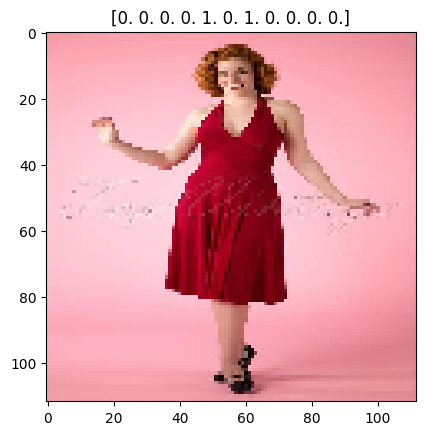

In [28]:
# 참고,  flower 자료와 같음.
import numpy as np
len(train_generator[0])   # 5578개를 32개씩 묶으면 175개의 묶음이 생기고 그중 첫번째 묶음자료는 img 32하고 레이블 32개로 구성됨
train_generator[0][1] # 레이블 

import matplotlib.pyplot as plt
plt.imshow(train_generator[0][0][0])
plt.title(train_generator[0][1][0])

for x in np.where(train_generator[0][1][0]==1):
    print(class_col[x])

In [34]:
model.fit(train_generator,
         steps_per_epoch=get_steps(len(train_df), batch_size),
         validation_data = val_generator,
         validation_steps=get_steps(len(val_df), batch_size),
         epochs = 1)

175/175 [==============================] - 10s 54ms/step - loss: 0.2242 - acc: 0.5088 - val_loss: 0.3118 - val_acc: 0.5270


In [35]:
# 5. 모델 평가하기
test_datagen = ImageDataGenerator(rescale = 1./255)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=base,
    x_col='image',
    y_col=class_col,
    target_size=(112, 112),
    color_mode='rgb',
    class_mode='raw',
    batch_size=batch_size,
    shuffle=True
)

loss_and_metrics = model.evaluate(test_generator,
                                  steps=get_steps(len(test_df), batch_size))
print('loss_and_metrics : ' + str(loss_and_metrics))

Found 3416 validated image filenames.
107/107 [==============================] - 5s 51ms/step - loss: 0.3061 - acc: 0.5064
loss_and_metrics : [0.3061085045337677, 0.506440281867981]


In [37]:
# 6. 모델 저장하기
import os
save_path = os.path.join('model', 'img_generator_model.h5')
model.save(save_path)

In [40]:
### 추가, 예측 
preds=model.predict(test_generator)
preds

array([[8.93500984e-01, 1.88484846e-04, 9.83329415e-01, ...,
        9.97648537e-01, 2.12323689e-03, 3.30496556e-03],
       [9.48042274e-01, 6.74088253e-03, 8.02310929e-02, ...,
        4.60028797e-02, 4.98443330e-03, 3.34282786e-01],
       [2.39581123e-01, 2.09122991e-05, 9.41028237e-01, ...,
        9.77243245e-01, 3.16376274e-04, 4.84208055e-02],
       ...,
       [3.99890900e-01, 2.74815094e-02, 1.72512546e-01, ...,
        4.14224952e-01, 1.99997076e-03, 9.70557928e-02],
       [1.63966551e-01, 2.73976610e-07, 9.97025192e-01, ...,
        2.33088583e-01, 1.17395030e-04, 7.80686200e-01],
       [4.57017122e-05, 1.19197803e-05, 5.05148530e-01, ...,
        2.39450224e-02, 1.13465474e-04, 1.28194997e-02]], dtype=float32)

In [50]:
### 참고
class_col[np.where(preds[0]==9.9764854e-01)]
class_col[np.where(preds[0]==9.8332942e-01)]


Index(['brown'], dtype='object')

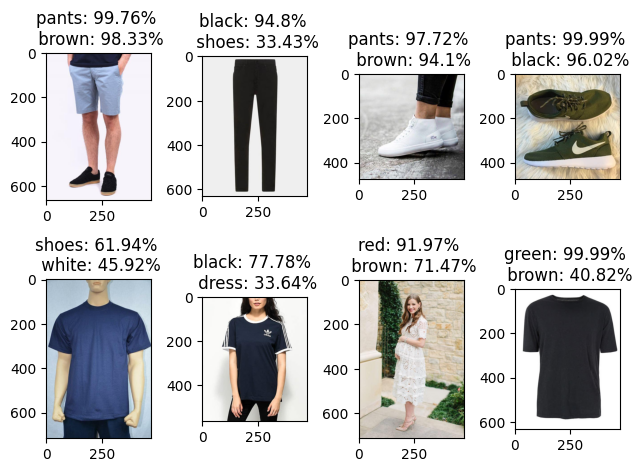

In [53]:
# 8개만 예측해보도록 하겠습니다.
do_preds = preds[:8]

import cv2
for i, pred in enumerate(do_preds):
    plt.subplot(2, 4, i + 1)
    prob = zip(class_col, list(pred))
    # item --> prob
    # contributor: '뱅커'님

    prob = sorted(list(prob), key = lambda z: z[1], reverse = True)[:2]

    image = cv2.imread(base+test_df['image'][i])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    plt.imshow(image)
    plt.title(f'{prob[0][0]}: {round(prob[0][1] * 100, 2)}% \n {prob[1][0]}: {round(prob[1][1] * 100, 2)}%')

plt.tight_layout()

black
brown
pants


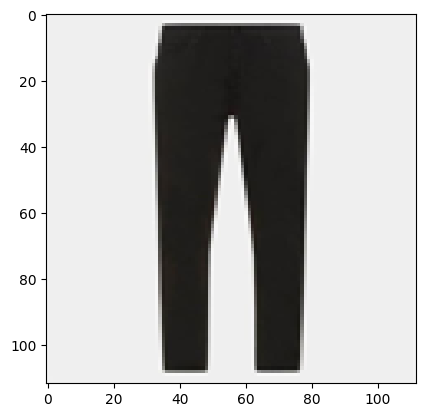

In [57]:
#### 만약 한개의 자료만 갖고서 예측한다면
## 새로운 데이터로 해야하지만
# 테스트자료 한개 꺼내서 에측하고자함
 
#

import numpy as np
from PIL import Image
base='D:/multiLabel/clothes/'
file=base+'./clothes_dataset/black_pants/0f8eb4509cea01f9656e8b31e3af0d29852cd90e.jpg'   
img=Image.open(file).resize((112,112))
img=np.array(img)

plt.imshow(img)
x_test=img.reshape(1, 112,112,3)
yhat = model.predict(x_test)

for x in np.where(yhat[0]==1)[0]:
    print(class_col[x])

